# One-Stage Kyle Model ($N=1$)

In [11]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

random_seed = 42


In [ ]:
asset_mean = 100.0
asset_stdev = 10.0
uninf_stdev = 1.0
asset_stdevs = np.arange(1, 50.1, 1)
uninformed_stdevs = np.arange(0.1, 3.01, 0.1)

Experiment setup: generate true value of an asset with the same mean but different standard deviations, from small to large. These are $p_0$ and $\sqrt\Sigma_0$ from the theorem. Uninformed traders have order flow with mean $0$ and stdev $\sigma_u$.

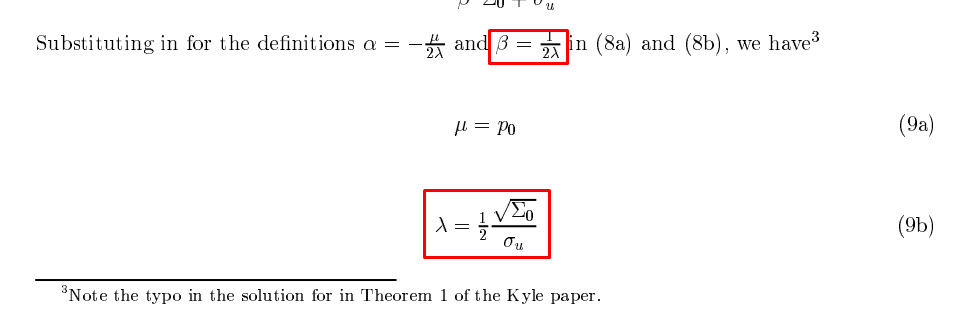

In [13]:
def get_kyle1_params(true_asset_stdev: float, uninf_stdev: float) -> tuple[float, float]:
    lmbd = true_asset_stdev / (2 * uninf_stdev)
    beta = 1 / (2 * lmbd)

    return lmbd, beta

def get_kyle1_lambda(asset_stdev, uninf_stdev):
    return asset_stdev / (2 * uninf_stdev)

def get_quotes(
    guess_price: float,
    market_maker_spread: float,
    true_asset_value: float,
    true_asset_stdev: float,
    uninf_stdev: float,
    iterations=100,
):
    order_flow = []

    market_maker_quotes = [(guess_price + market_maker_spread, guess_price - market_maker_spread)]

    lmbd, beta = get_kyle1_params(true_asset_stdev, uninf_stdev)

    for i in range(iterations):
        midprice = (market_maker_quotes[-1][0] + market_maker_quotes[-1][1]) / 2

        uninformed_trader_of = np.random.normal(0, uninf_stdev)

        informed_trader_of = beta * (true_asset_value - midprice)

        total_order_flow = uninformed_trader_of + informed_trader_of

        # update market maker quotes
        last_bid = market_maker_quotes[-1][0]
        last_ask = market_maker_quotes[-1][1]

        price_adjustment = lmbd * total_order_flow

        new_bid, new_ask = last_bid + price_adjustment, last_ask + price_adjustment

        order_flow.append(total_order_flow)
        market_maker_quotes.append((new_bid, new_ask))

    return market_maker_quotes, lmbd, beta

In [25]:
np.random.seed(random_seed)

true_asset_value = np.random.normal(asset_mean, asset_stdev)
market_maker_quotes, lmbd, beta = get_quotes(
    150, 2, true_asset_value, asset_stdev, uninf_stdev, 50
)

bids = [x[0] for x in market_maker_quotes]
asks = [x[1] for x in market_maker_quotes]

# plot bids and asks

plotly_fig = go.Figure()

plotly_fig.add_trace(go.Scatter(x=list(range(100)), y=bids, mode="lines+markers", name="Bids"))
plotly_fig.add_trace(go.Scatter(x=list(range(100)), y=asks, mode="lines+markers", name="Asks"))
plotly_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    yanchor="top",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

plotly_fig.show()

Surface of lambdas:

In [15]:
assets_x, uninfs_y = np.meshgrid(asset_stdevs, uninformed_stdevs)
lmbd_z = get_kyle1_lambda(assets_x, uninfs_y)

lmbd_fig = go.Figure(go.Surface(x=assets_x, y=uninfs_y, z=lmbd_z, colorbar_thickness=24))

lmbd_fig.update_layout(
    title=dict(text="Lambda Surface")
)
lmbd_fig.update_layout(width=600, height=600, font_size=12,
    scene=dict(
        xaxis = dict(title="Asset StDev"),
        yaxis = dict(title="Uninformed StDev"),
        zaxis =dict(title="Lambda")
    ))

lmbd_fig.show()